In [42]:
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np
import os
import sys
from pathlib import Path
import pickle
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from plotnine import ggplot, aes, geom_bar, geom_point, facet_wrap, labs, theme_bw, geom_histogram
pd.set_option('display.max_columns', None)
sys.path.append(os.path.abspath('..'))
from Scoreci.config import PROCESSED_DATA_DIR, MODELS_DIR

In [3]:
df = pd.read_parquet(os.path.join(PROCESSED_DATA_DIR,'datos_entrenamiento_vf.parquet'))

In [4]:
df.head()

,PCNT_FPD_T0,AVG_ATRASO_ACT_EXP_T1,SE_MANTIENE_ATRASO_PCT_CATS_T0,SE_MANTIENE_0_PCT_CATS_T1,CR8A60_SIN_EXP_T0,SE_MANTIENE_ATRASO_PCT_T1,PORC_CR_T1,C_COBRANZA_T0,SE_MANTIENE_0_PCT_T2,CR8A60_CON_EXP_T2,EMPEORA_T2,EMPEORA_CATS_T0,PORC_CR_T2,SE_MANTIENE_0_PCT_T1,AVG_CICLOS_EJE_T1,CTES8A60_SIN_EXP_T2,AVG_ATRASO_ACT_EXP_T2,PORC_CR_T10,CR8A60_CON_EXP_T1,CTES8A60_SIN_EXP_T1,EMPEORA_CATS_T1,SE_MANTIENE_ATRASO_PCT_T0,SE_MANTIENE_0_PCT_CATS_T2,AVG_CICLOS_EJE_T0,DESEMBOLSOS_SIN_EXP_T0,AVG_CICLOS_EJE_T2,TOT_MAC_T0,EMPEORA_CATS_T2,SE_MANTIENE_ATRASO_PCT_CATS_T2,DESEMBOLSOS_CON_EXP_T0,EMPEORA_T1,PORC_CR_T0,CR8A60_SIN_EXP_T1,SE_MANTIENE_0_PCT_T0,EMPEORA_T0,CR8A60_SIN_EXP_T2,AVG_ATRASO_ACT_EXP_T0,SE_MANTIENE_ATRASO_PCT_CATS_T1,SE_MANTIENE_0_PCT_CATS_T0,PCNT_FPD_T1,y
ASESOR_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1949827,0.152381,0.683673,0.009259,0.970874,90888.16,0.006920,0.018219,8.0,0.955265,0.00,0.009064,0.037037,0.033791,0.978869,5.097345,6,2.980392,0.037075,0.00,3,0.019417,0.005256,0.940000,5.091667,11,5.563025,120,0.010000,0.050000,1,0.014211,0.020897,89830.95,0.969130,0.020602,168818.32,1.457143,0.009709,0.944444,0.145455,0.040606
1949838,0.065789,0.181818,0.017167,0.944444,343087.18,0.004296,0.012228,10.0,0.964142,36711.70,0.010338,0.051502,0.025734,0.966596,8.355102,7,1.815029,0.028392,60001.33,2,0.041667,0.011261,0.950226,8.282258,6,8.384298,248,0.013575,0.027149,9,0.023876,0.034199,69544.34,0.953349,0.032512,214705.01,1.600000,0.004630,0.922747,0.062500,0.021462
1949853,0.031008,0.965517,0.000000,0.969466,0.00,0.003437,0.005416,5.0,0.958710,140976.64,0.023682,0.031008,0.031179,0.977713,8.816901,2,0.538462,0.002753,0.00,3,0.015267,0.000000,0.952000,8.829787,9,8.645833,141,0.016000,0.032000,3,0.002687,0.014247,35154.38,0.975441,0.024559,61941.89,0.026087,0.007634,0.968992,0.028169,0.036736
1950001,0.088000,1.046512,0.054688,0.909091,95096.37,0.013819,0.020934,2.0,0.976219,0.00,0.012259,0.031250,0.009430,0.940280,7.956835,2,0.567901,0.016517,74428.45,3,0.041322,0.037346,0.947368,8.062069,11,8.038462,145,0.035088,0.017544,6,0.039734,0.022762,79940.91,0.928337,0.034317,64086.21,0.898876,0.033058,0.914062,0.095588,0.049911
1950569,0.154930,2.082569,0.013245,0.945205,0.00,0.020399,0.021350,3.0,0.977527,0.00,0.020058,0.013245,0.019388,0.973692,7.220238,6,1.528302,0.013959,46664.30,5,0.013699,0.004897,0.954248,7.069767,13,7.463415,170,0.032680,0.013072,8,0.005908,0.015462,156927.55,0.980662,0.012421,169548.76,0.000000,0.041096,0.966887,0.150943,0.019222


In [5]:
df.drop(columns=['C_COBRANZA_T0','PORC_CR_T10','TOT_MAC_T0'], inplace=True, axis=0)

In [6]:
X = df.drop(columns=['y'])
y = df['y']

In [7]:
print(X.shape),print(y.shape) 

(1722, 37)
(1722,)


(None, None)

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [10]:
parametros_modelos = {
    'Regresión Lineal': {
        'modelo': LinearRegression(),
        'parametros': {}  # No tiene hiperparámetros relevantes
    },
    'Huber Regressor': {
        'modelo': HuberRegressor(),
        'parametros': {
            'epsilon': [1.1, 1.35, 1.5, 1.75],
            'alpha': [0.0001, 0.001, 0.01]
        }
    },
    'Random Forest': {
        'modelo': RandomForestRegressor(random_state=42),
        'parametros': {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, 15],
            'min_samples_split': [2, 5, 10]
        }
    },
    'XGBoost': {
        'modelo': XGBRegressor(random_state=42, verbosity=0),
        'parametros': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2]
        }
    }
}

In [11]:
mejores_modelos = []
for modelo, config  in parametros_modelos.items():
    print(f'Entrenando Grid Search para: {modelo}')
    grid = GridSearchCV(config ['modelo'], config ['parametros'], cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)

    mejores_modelos.append({
        'Modelo': modelo,
        'Mejores Hiperparámetros': grid.best_params_,
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R²': r2_score(y_test, y_pred)
    })

Entrenando Grid Search para: Regresión Lineal
Entrenando Grid Search para: Huber Regressor
Entrenando Grid Search para: Random Forest
Entrenando Grid Search para: XGBoost


In [13]:
resultados = pd.DataFrame(mejores_modelos)
print('\nComparación de Modelos:')
print(resultados)


Comparación de Modelos:
             Modelo                            Mejores Hiperparámetros  \
0  Regresión Lineal                                                 {}   
1   Huber Regressor                   {'alpha': 0.01, 'epsilon': 1.35}   
2     Random Forest  {'max_depth': 5, 'min_samples_split': 10, 'n_e...   
3           XGBoost  {'learning_rate': 0.01, 'max_depth': 5, 'n_est...   

        MAE      RMSE        R²  
0  0.019018  0.032896 -0.229092  
1  0.014124  0.028525  0.075830  
2  0.016709  0.032810 -0.222646  
3  0.015669  0.029851 -0.012074  


In [33]:
resultados.loc[3, 'Mejores Hiperparámetros']

{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}

In [14]:
for metrica in ['MAE Promedio', 'RMSE Promedio']:
    plot = (
        ggplot(resultados, aes(x='Modelo', y=metrica, fill='Modelo')) +
        geom_bar(stat='identity', show_legend=False) +
        labs(title=f'Comparación de {metrica}', y=metrica, x='Modelo') +
        theme_bw()
    )

In [15]:
df_errores = pd.DataFrame()
mejores_modelos = []

In [16]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, shapiro, kstest, skew, kurtosis

In [17]:
for model, config in parametros_modelos.items():
    print(f'Entrenando Grid Search para: {model}')
    grid = GridSearchCV(config['modelo'], config['parametros'], cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)
    df_error = pd.DataFrame({
        'Modelo': model,
        'Error': y_test - y_pred
    })
    df_errores = pd.concat([df_errores, df_error], ignore_index=True)

    mejores_modelos.append({
        'Modelo': model,
        'Mejores Hiperparámetros': grid.best_params_,
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R²': r2_score(y_test, y_pred)
    })

Entrenando Grid Search para: Regresión Lineal
Entrenando Grid Search para: Huber Regressor
Entrenando Grid Search para: Random Forest
Entrenando Grid Search para: XGBoost


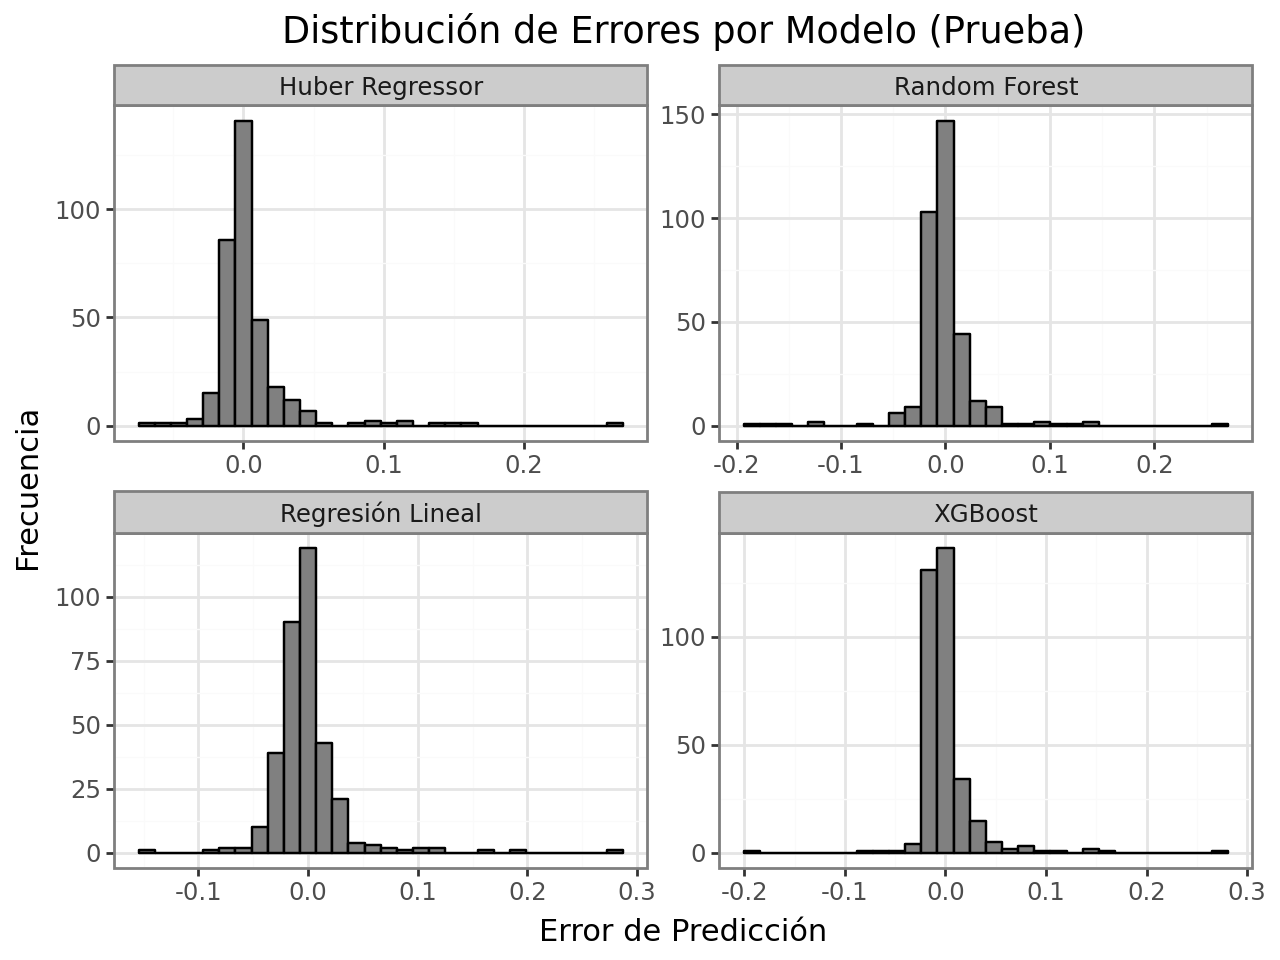

In [18]:
# grafico de los errores
plot_error = (
    ggplot(df_errores, aes(x='Error')) +
    geom_histogram(bins=30, fill='gray', color='black') +
    facet_wrap('~Modelo', scales='free') +
    labs(title='Distribución de Errores por Modelo (Prueba)', x='Error de Predicción', y='Frecuencia') +
    theme_bw()
)

plot_error

In [19]:
modelos = df_errores['Modelo'].unique()
num_modelos = len(modelos)

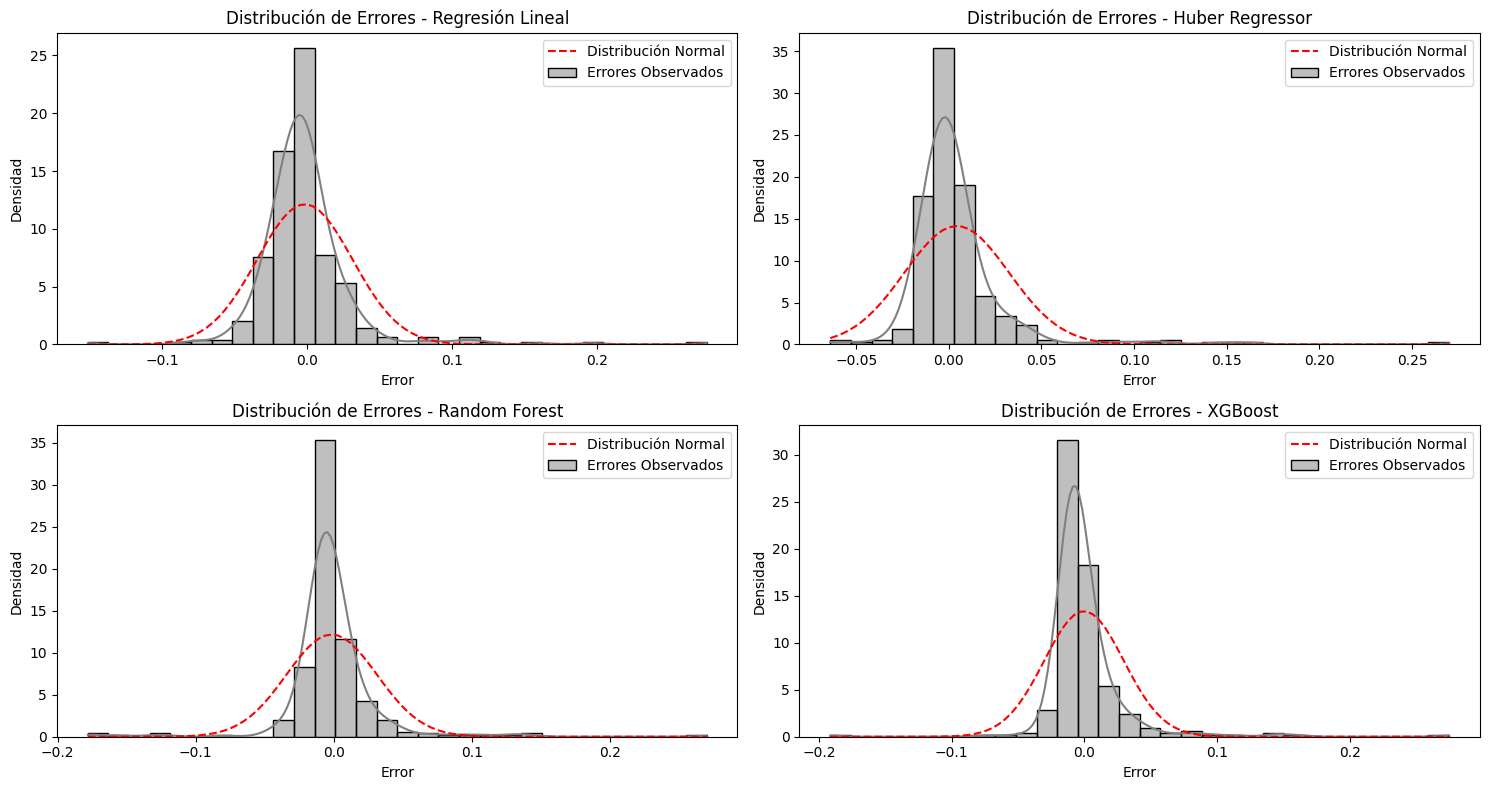

In [20]:
fig, axes = plt.subplots(nrows=(num_modelos + 1) // 2, ncols=2, figsize=(15, 4 * ((num_modelos + 1) // 2)))
axes = axes.flatten()
estadisticos = []

for i, modelo in enumerate(modelos):
    errores = df_errores[df_errores['Modelo'] == modelo]['Error']
    # Estadísticos descriptivos
    mu = errores.mean()
    sigma = errores.std()
    skewness = skew(errores)
    kurt = kurtosis(errores)
    # Pruebas de normalidad
    shapiro_stat, shapiro_p = shapiro(errores)
    ks_stat, ks_p = kstest(errores, 'norm', args=(mu, sigma))
    estadisticos.append({
        'Modelo': modelo,
        'Media': mu,
        'Desviación Estándar': sigma,
        'Asimetría (Skewness)': skewness,
        'Curtosis': kurt,
        'Shapiro-Wilk p-value': shapiro_p,
        'Kolmogorov-Smirnov p-value': ks_p
    })
    sns.histplot(errores, bins=30, kde=True, stat='density', ax=axes[i], color='gray', label='Errores Observados')
    x = np.linspace(errores.min(), errores.max(), 100)
    y = norm.pdf(x, mu, sigma)
    axes[i].plot(x, y, 'r--', label='Distribución Normal')
    axes[i].set_title(f'Distribución de Errores - {modelo}')
    axes[i].set_xlabel('Error')
    axes[i].set_ylabel('Densidad')
    axes[i].legend()
plt.tight_layout()
plt.show()

In [22]:
# Resumen de estadísticos
df_estadisticos = pd.DataFrame(estadisticos)
print('\nResumen Estadísticos de Normalidad por Modelo:')
print(df_estadisticos)


Resumen Estadísticos de Normalidad por Modelo:
             Modelo     Media  Desviación Estándar  Asimetría (Skewness)  \
0  Regresión Lineal -0.001392             0.032915              2.931035   
1   Huber Regressor  0.004278             0.028244              4.385618   
2     Random Forest -0.001576             0.032820              1.087140   
3           XGBoost -0.000365             0.029892              3.088837   

    Curtosis  Shapiro-Wilk p-value  Kolmogorov-Smirnov p-value  
0  21.113228          6.695607e-23                8.035031e-10  
1  29.852224          6.859511e-27                4.392888e-16  
2  21.946914          9.541915e-26                5.651021e-14  
3  30.237882          3.799815e-27                1.408273e-13  


In [23]:
df_resultados = pd.DataFrame(mejores_modelos)
#ranking basado en MAE
df_resultados['Rank_MAE'] = df_resultados['MAE'].rank(method='min', ascending=True)
top_mae = df_resultados.loc[df_resultados['Rank_MAE'] == 1]
# Verificar si hay más de un modelo con MAE similar (diferencia < 1%)
if len(top_mae) > 1:
    mae_threshold = top_mae['MAE'].min() * 1.01
    filtered_models = df_resultados[df_resultados['MAE'] <= mae_threshold]
    best_model_row = filtered_models.sort_values(by='R²', ascending=False).iloc[0]
else:
    best_model_row = top_mae.iloc[0]
print('\nTabla Final de Resultados:')
print(df_resultados[['Modelo', 'MAE', 'RMSE', 'R²', 'Mejores Hiperparámetros']])

print('\n👉 El mejor modelo sugerido es:')
print(f"Modelo: {best_model_row['Modelo']}")
print(f"Hiperparámetros: {best_model_row['Mejores Hiperparámetros']}")
print(f"MAE: {best_model_row['MAE']:.5f}")
print(f"RMSE: {best_model_row['RMSE']:.5f}")
print(f"R²: {best_model_row['R²']:.5f}")



Tabla Final de Resultados:
             Modelo       MAE      RMSE        R²  \
0  Regresión Lineal  0.019018  0.032896 -0.229092   
1   Huber Regressor  0.014124  0.028525  0.075830   
2     Random Forest  0.016709  0.032810 -0.222646   
3           XGBoost  0.015669  0.029851 -0.012074   

                             Mejores Hiperparámetros  
0                                                 {}  
1                   {'alpha': 0.01, 'epsilon': 1.35}  
2  {'max_depth': 5, 'min_samples_split': 10, 'n_e...  
3  {'learning_rate': 0.01, 'max_depth': 5, 'n_est...  

👉 El mejor modelo sugerido es:
Modelo: Huber Regressor
Hiperparámetros: {'alpha': 0.01, 'epsilon': 1.35}
MAE: 0.01412
RMSE: 0.02853
R²: 0.07583


In [34]:
modelo_final =  HuberRegressor(max_iter=1000,alpha=0.01, epsilon=1.35)

In [35]:
hubber_model = modelo_final.fit(X_train, y_train)

In [36]:
y_pred_hubber = hubber_model.predict(X_test)

In [37]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_hubber))

MAE: 0.014123220737582175


In [39]:
coeficientes_df = pd.DataFrame({'Característica': X.columns, 'Coeficiente': hubber_model.coef_})
coeficientes_df.sort_values(by='Coeficiente', ascending=False, inplace=True)
coeficientes_df.head()

,Característica,Coeficiente
2,SE_MANTIENE_ATRASO_PCT_CATS_T0,0.008462
10,EMPEORA_CATS_T0,0.007458
35,SE_MANTIENE_0_PCT_CATS_T0,0.007381
28,PORC_CR_T0,0.005661
20,SE_MANTIENE_0_PCT_CATS_T2,0.005605


In [45]:
with open(os.path.join(MODELS_DIR,'modelo_autonomia.pkl'), 'wb') as archivo_salida:
    pickle.dump(hubber_model, archivo_salida)

In [44]:
with open(os.path.join(MODELS_DIR,'escalador_autonomia.pkl'), 'wb') as archivo_salida:
    pickle.dump(scaler, archivo_salida)